### 1. 데이터 불러오기 및 전처리

In [ ]:
# 수집된 데이터 불러오기
import pandas as pd

df1 = pd.read_csv("../data/review-rating1.csv")
df2 = pd.read_csv("../data/review-rating2.csv")
df3 = pd.read_csv("../data/review-rating3.csv")
df4 = pd.read_csv("../data/review-rating4.csv")

df = pd.concat([df1, df2, df3, df4])
df.head()

,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 100% 성공이다. 원래 한국영화들 속편은 잘 안되고 속편 나오면...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요. 유머도 내 스타일이라...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요. 나쁜놈들 잡는 캐릭터로...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 1편도 2편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 ...,0,범죄도시2,8.99


In [ ]:
# 인덱스 재설정
df.reset_index(drop=True, inplace=True)
df.head()

,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 100% 성공이다. 원래 한국영화들 속편은 잘 안되고 속편 나오면...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요. 유머도 내 스타일이라...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요. 나쁜놈들 잡는 캐릭터로...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 1편도 2편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 ...,0,범죄도시2,8.99


In [ ]:
# 데이터 크기 확인
len(df)

1183849

In [ ]:
# 중복되지 않은 데이터 확인
df['리뷰'].nunique(), df['실제평점'].nunique()


(1060077, 10)

In [ ]:
df.duplicated().sum()

45854

In [ ]:
# 중복값 제거
df.drop_duplicates(inplace=True)
len(df)

1137995

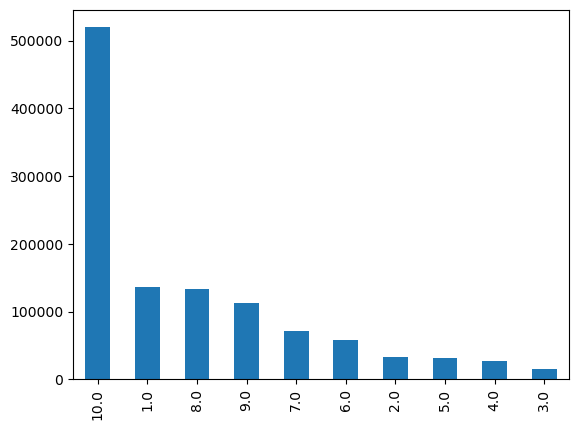

In [ ]:
# 평점 분포 그래프
import matplotlib.pyplot as plt
df['실제평점'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# 특수문자,기호 제거
df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df[:5]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_4232\2647383859.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,실제평점,리뷰,영화ID,영화명,평균평점
0,10.0,이 영화의 속편은 성공이다 원래 한국영화들 속편은 잘 안되고 속편 나오면 망하는 ...,0,범죄도시2,8.99
1,10.0,진짜 재미있어요잔인한 거 잘 못 보는데 충분히 볼 수 있구요 유머도 내 스타일이라 ...,0,범죄도시2,8.99
2,10.0,넘 재밌어요 시원시원하고 계속 시리즈로 나왔으면 좋겠어요 나쁜놈들 잡는 캐릭터로는...,0,범죄도시2,8.99
3,10.0,솔직하게 장첸보다 강해상이 더 강해보인다,0,범죄도시2,8.99
4,10.0,범죄도시 편도 편도 다 악역배우 연기가 진짜 미쳤다 ㅠㅠㅠ 마동석 배우 액션도 진짜...,0,범죄도시2,8.99


In [ ]:
# 공백 제거
import numpy as np

df['리뷰'] = df['리뷰'].str.replace('^ +', "")
df['리뷰'].replace('', np.nan, inplace=True)
df.isnull().sum()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_4232\4057912268.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['리뷰'] = df['리뷰'].str.replace('^ +', "")


실제평점       0
리뷰      6145
영화ID       0
영화명        0
평균평점       0
dtype: int64

In [ ]:
df.loc[df['리뷰'].isnull()][:5]

,실제평점,리뷰,영화ID,영화명,평균평점
565,10.0,NaN,1,아바타: 물의 길,8.82
707,10.0,NaN,2,탑건: 매버릭,9.60
743,10.0,NaN,2,탑건: 매버릭,9.60
786,8.0,NaN,2,탑건: 매버릭,9.60
909,10.0,NaN,2,탑건: 매버릭,9.60


In [ ]:
# null 샘플 제거
df = df.dropna(how = 'any')
len(df)

1131850

In [ ]:
# 불용어 사전
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [ ]:
# 불용어 추가
add_stopwords = ['ㅠ', 'ㅠㅠ', 'ㅠㅠㅠ', 'ㅋ', 'ㅋㅋ', 'ㅋㅋㅋ', 
                 '마블', '트랜스포머', '올빼미', '디즈니', '마동석', 
                 '영화', '애니메이션', '영화관', '오프닝', '다큐멘터리', 
                 '한국영화', '코로나', '스크린']
for word in add_stopwords:
    stopwords.append(word)

In [ ]:
# 독립변수 X, 종속변수 y, 종속변수 원핫인코딩
X = df['리뷰']
y = pd.get_dummies(df['실제평점'])


In [ ]:
# 종속변수 실수 변환
y = y.astype('float64')

In [ ]:
# 학습용 8, 검증용 2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()
X_train_lis = []

# 형태소 분석
for sentence in tqdm(X_train):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_lis.append(temp_X)

100%|██████████| 905480/905480 [2:52:38<00:00, 87.42it/s]   


In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm

okt = Okt()
X_test_lis = []

# 형태소 분석
for sentence in tqdm(X_test):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_lis.append(temp_X)

100%|██████████| 226370/226370 [1:26:18<00:00, 43.72it/s]  


In [ ]:
# 형태소 분석 완료 데이터 중간저장
import csv
with open('../data/X_test_lis.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_test_lis)

with open('../data/X_train_lis.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_train_lis)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lis)
print(tokenizer.word_index)

In [ ]:
# 출현빈도가 2회 미만인 단어들
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print(total_cnt) # 단어집합 크기
print(rare_cnt) # 희귀단어수

# total_cnt = 92909 단어집합 크기
# rare_cnt = 38658 희귀단어수

92909
38658


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

# vocab_size = 54252

단어 집합의 크기 : 54252


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_lis) # 텍스트를 숫자 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train_lis)
X_test = tokenizer.texts_to_sequences(X_test_lis)

In [ ]:
print(X_train[:3])

[[34, 189, 218, 7, 906, 245, 381, 10, 98, 1646], [982, 2500, 1528, 3705, 90, 566, 170], [44, 19, 37, 15, 27, 157, 40, 35, 14]]


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# 종속변수 저장
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)

In [3]:
# 종속변수 불러오기
import numpy as np

y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

In [ ]:
# 독립변수 저장
import csv
with open('../data/X_test.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_test)

with open('../data/X_train.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(X_train)

In [4]:
# 독립변수 불러오기
import csv

X_train = []
with open('../data/X_train.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        for row2 in row:
            row3 = [float(num) for num in row2.strip('[]').split(',') if num.strip()]
            X_train.append(row3)

X_test = []
with open('../data/X_test.csv', 'r', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        for row2 in row:
            row3 = [float(num) for num in row2.strip('[]').split(',') if num.strip()]
            X_test.append(row3)

In [5]:
max_len = max(len(l) for l in X_train) # 리뷰의 최대 길이
max_len
# max_len = 384

384

In [4]:
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
# 최대 길이 이하인 샘플의 비율
(cnt / len(X_train))*100

# 86.44034103458938

86.44034103458938

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [7]:
# 기본 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 54252

def build_model1(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length=max_len))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model1 = build_model1(vocab_size, max_len, num_classes)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 384, 128)          6944256   
                                                                 
 conv1d (Conv1D)             (None, 384, 256)          164096    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 76, 256)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 19456)             0         
                                                                 
 dense (Dense)               (None, 10)                194570    
                                                                 
Total params: 7,302,922
Trainable params: 7,302,922
Non-trainable params: 0
______________________________________________

In [8]:
# 모델 훈련을 위한 콜백 설정
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../review_CNN_origin_cp.h5', save_best_only=True)

In [9]:
# 모델 훈련
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 235s 21ms/step - loss: 1.4800 - accuracy: 0.5152 - val_loss: 1.4398 - val_accuracy: 0.5242
Epoch 2/10
11319/11319 [==============================] - 158s 14ms/step - loss: 1.3812 - accuracy: 0.5376 - val_loss: 1.4494 - val_accuracy: 0.5209
Epoch 3/10
11319/11319 [==============================] - 165s 15ms/step - loss: 1.2755 - accuracy: 0.5686 - val_loss: 1.5130 - val_accuracy: 0.5073
Epoch 4/10
11319/11319 [==============================] - 163s 14ms/step - loss: 1.1440 - accuracy: 0.6137 - val_loss: 1.6271 - val_accuracy: 0.5011


In [10]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model1.history.history['loss']
val_loss = model1.history.history['val_loss']
train_acc = model1.history.history['accuracy']
val_acc = model1.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.4800211191177368
0.5152419209480286
1.4398205280303955
0.5242302417755127


In [11]:
# 모델 평가
model1.evaluate(X_test, y_test)

7075/7075 [==============================] - 26s 4ms/step - loss: 1.4438 - accuracy: 0.5222


[1.4438436031341553, 0.522171676158905]

In [12]:
pred1 = model1.predict(X_test)

7075/7075 [==============================] - 18s 3ms/step


In [13]:
pred1_binary = np.where(pred1 <= 0.5, 0, 1)

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred1_binary)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.37      0.49     26972
           1       0.07      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       1.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.31      0.00      0.00     11590
           6       0.45      0.00      0.00     14141
           7       0.29      0.00      0.00     26539
           8       0.36      0.00      0.00     22452
           9       0.69      0.65      0.67    103401

   micro avg       0.69      0.34      0.46    226370
   macro avg       0.39      0.10      0.12    226370
weighted avg       0.54      0.34      0.36    226370
 samples avg       0.34      0.34      0.34    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 모델 저장
model1.save('../model/review_CNN_1.h5')

In [16]:
# 합성곱 레이어 추가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 54252

def build_model2(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length=max_len))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model2 = build_model2(vocab_size, max_len, num_classes)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 384, 128)          6944256   
                                                                 
 conv1d_1 (Conv1D)           (None, 384, 256)          164096    
                                                                 
 conv1d_2 (Conv1D)           (None, 384, 128)          163968    
                                                                 
 conv1d_3 (Conv1D)           (None, 384, 64)           41024     
                                                                 
 conv1d_4 (Conv1D)           (None, 384, 32)           10272     
                                                                 
 conv1d_5 (Conv1D)           (None, 384, 16)           2576      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 76, 16)          

In [17]:
# 모델 훈련
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 349s 31ms/step - loss: 1.4571 - accuracy: 0.5232 - val_loss: 1.3716 - val_accuracy: 0.5409
Epoch 2/10
11319/11319 [==============================] - 282s 25ms/step - loss: 1.3651 - accuracy: 0.5425 - val_loss: 1.3585 - val_accuracy: 0.5431
Epoch 3/10
11319/11319 [==============================] - 277s 24ms/step - loss: 1.3189 - accuracy: 0.5530 - val_loss: 1.3631 - val_accuracy: 0.5445
Epoch 4/10
11319/11319 [==============================] - 278s 25ms/step - loss: 1.2754 - accuracy: 0.5635 - val_loss: 1.3693 - val_accuracy: 0.5433
Epoch 5/10
11319/11319 [==============================] - 298s 26ms/step - loss: 1.2288 - accuracy: 0.5750 - val_loss: 1.4031 - val_accuracy: 0.5409


In [18]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model2.history.history['loss']
val_loss = model2.history.history['val_loss']
train_acc = model2.history.history['accuracy']
val_acc = model2.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.457138180732727
0.5232142210006714
1.371583342552185
0.5409064888954163


In [19]:
# 모델 평가
model2.evaluate(X_test, y_test)

7075/7075 [==============================] - 37s 5ms/step - loss: 1.3623 - accuracy: 0.5427


[1.3623095750808716, 0.5427044034004211]

In [20]:
pred2 = model2.predict(X_test)

7075/7075 [==============================] - 27s 4ms/step


In [21]:
pred2_binary = np.where(pred2 <= 0.5, 0, 1)

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred2_binary)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.42      0.53     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.00      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.73      0.68      0.70    103401

   micro avg       0.73      0.36      0.48    226370
   macro avg       0.15      0.11      0.12    226370
weighted avg       0.42      0.36      0.38    226370
 samples avg       0.36      0.36      0.36    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# 모델 저장
model2.save('../model/review_CNN_2.h5')

In [6]:
# 커널사이즈 감소, 맥스풀링 증가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 54252

def build_model3(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length=max_len))
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', strides = 1))
    model.add(MaxPooling1D(10))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # 다중 분류에는 'softmax' 활성화 함수 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 'categorical_crossentropy'와 'accuracy' 사용
    return model

num_classes = 10  # 분류하려는 클래스의 개수
model3 = build_model3(vocab_size, max_len, num_classes)
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 384, 128)          6944256   
                                                                 
 conv1d (Conv1D)             (None, 384, 256)          98560     
                                                                 
 conv1d_1 (Conv1D)           (None, 384, 128)          98432     
                                                                 
 conv1d_2 (Conv1D)           (None, 384, 64)           24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 384, 32)           6176      
                                                                 
 conv1d_4 (Conv1D)           (None, 384, 16)           1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 16)           0

In [8]:
# 모델 훈련
model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 294s 25ms/step - loss: 1.4949 - accuracy: 0.5164 - val_loss: 1.3903 - val_accuracy: 0.5350
Epoch 2/10
11319/11319 [==============================] - 224s 20ms/step - loss: 1.4105 - accuracy: 0.5330 - val_loss: 1.3819 - val_accuracy: 0.5385
Epoch 3/10
11319/11319 [==============================] - 230s 20ms/step - loss: 1.3747 - accuracy: 0.5408 - val_loss: 1.3760 - val_accuracy: 0.5417
Epoch 4/10
11319/11319 [==============================] - 233s 21ms/step - loss: 1.3429 - accuracy: 0.5484 - val_loss: 1.3745 - val_accuracy: 0.5417
Epoch 5/10
11319/11319 [==============================] - 226s 20ms/step - loss: 1.3135 - accuracy: 0.5557 - val_loss: 1.3848 - val_accuracy: 0.5407
Epoch 6/10
11319/11319 [==============================] - 216s 19ms/step - loss: 1.2833 - accuracy: 0.5632 - val_loss: 1.3996 - val_accuracy: 0.5387
Epoch 7/10
11319/11319 [==============================] - 220s 19ms/step - loss: 1.2524 - accuracy: 0.5708

In [9]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model3.history.history['loss']
val_loss = model3.history.history['val_loss']
train_acc = model3.history.history['accuracy']
val_acc = model3.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.494875431060791
0.5163987874984741
1.390289545059204
0.535020112991333


In [10]:
# 모델 평가
model3.evaluate(X_test, y_test)

7075/7075 [==============================] - 31s 4ms/step - loss: 1.3771 - accuracy: 0.5406


[1.3771028518676758, 0.5405575037002563]

In [11]:
pred3 = model3.predict(X_test)

7075/7075 [==============================] - 22s 3ms/step


In [12]:
pred3_binary = np.where(pred3 <= 0.5, 0, 1)

In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred3_binary)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.54      0.59     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.83      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.72      0.70      0.71    103401

   micro avg       0.71      0.38      0.50    226370
   macro avg       0.22      0.12      0.13    226370
weighted avg       0.51      0.38      0.39    226370
 samples avg       0.38      0.38      0.38    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# 모델 저장
model3.save('../model/review_CNN_3.h5')

In [8]:
# 노이즈 추가, 맥스풀링 추가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

vocab_size = 54252

def build_model5(vocab_size, max_len, num_classes):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length=max_len))
    model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

num_classes = 10
model5 = build_model5(vocab_size, max_len, num_classes)
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 384, 128)          6944256   
                                                                 
 conv1d (Conv1D)             (None, 384, 256)          164096    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 192, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 128)          163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 192, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 96, 64)           0         
 1D)                                                    

In [9]:
# 노이즈
X_train_noise = X_train + np.random.normal(0, 0.01, size = X_train.shape)
y_train_noise = y_train + np.random.normal(0, 0.01, size = y_train.shape)

In [10]:
# 모델 훈련
model5.fit(X_train_noise, y_train_noise, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
11319/11319 [==============================] - 318s 27ms/step - loss: 1.5977 - accuracy: 0.5022 - val_loss: 1.5152 - val_accuracy: 0.5143
Epoch 2/10
11319/11319 [==============================] - 244s 22ms/step - loss: 1.4787 - accuracy: 0.5216 - val_loss: 1.4770 - val_accuracy: 0.5203
Epoch 3/10
11319/11319 [==============================] - 243s 21ms/step - loss: 1.4150 - accuracy: 0.5359 - val_loss: 1.4661 - val_accuracy: 0.5210
Epoch 4/10
11319/11319 [==============================] - 241s 21ms/step - loss: 1.3583 - accuracy: 0.5489 - val_loss: 1.4987 - val_accuracy: 0.5172
Epoch 5/10
11319/11319 [==============================] - 243s 21ms/step - loss: 1.3029 - accuracy: 0.5621 - val_loss: 1.5427 - val_accuracy: 0.5091
Epoch 6/10
11319/11319 [==============================] - 241s 21ms/step - loss: 1.2590 - accuracy: 0.5738 - val_loss: 1.6137 - val_accuracy: 0.4942


In [11]:
# 훈련 과정의 손실값과 정확도 확인
train_loss = model5.history.history['loss']
val_loss = model5.history.history['val_loss']
train_acc = model5.history.history['accuracy']
val_acc = model5.history.history['val_accuracy']
print(train_loss[0])
print(train_acc[0])
print(val_loss[0])
print(val_acc[0])

1.5976982116699219
0.5022474527359009
1.5152140855789185
0.5142797231674194


In [12]:
# 모델 평가
model5.evaluate(X_test, y_test)

7075/7075 [==============================] - 34s 5ms/step - loss: 1.4707 - accuracy: 0.5210


[1.4707094430923462, 0.5209921598434448]

In [13]:
pred5 = model5.predict(X_test)

7075/7075 [==============================] - 24s 3ms/step


In [14]:
pred5_binary = np.where(pred5 <= 0.5, 0, 1)

In [16]:
from sklearn.metrics import classification_report

report = classification_report(y_test, pred5_binary)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      0.33      0.45     26972
           1       0.00      0.00      0.00      6576
           2       0.00      0.00      0.00      3060
           3       0.00      0.00      0.00      5302
           4       0.00      0.00      0.00      6337
           5       0.00      0.00      0.00     11590
           6       0.00      0.00      0.00     14141
           7       0.00      0.00      0.00     26539
           8       0.00      0.00      0.00     22452
           9       0.68      0.70      0.69    103401

   micro avg       0.68      0.36      0.47    226370
   macro avg       0.14      0.10      0.11    226370
weighted avg       0.40      0.36      0.37    226370
 samples avg       0.36      0.36      0.36    226370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# 모델 저장
model5.save('../model/review_CNN_5.h5')

In [ ]:
# 모델 로드
model = load_model('../model/review_CNN_3.h5')